In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


In [2]:
# Load the Titanic dataset
titanic = pd.read_csv("data/titanic.csv")

# Perform simple feature engineering
titanic['Age'].fillna(titanic['Age'].median(), inplace=True)
titanic['Embarked'].fillna(titanic['Embarked'].mode()[0], inplace=True)
titanic['Fare'].fillna(titanic['Fare'].median(), inplace=True)
titanic['Cabin'].fillna("Unknown", inplace=True)
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch']
titanic['IsAlone'] = np.where(titanic['FamilySize'] > 0, 0, 1)
titanic['Title'] = titanic['Name'].str.extract(' ([A-Za-z]+)\.')

# Encode categorical variables
label_encoders = {}
for col in ['Sex', 'Embarked', 'Cabin', 'Title']:
    label_encoders[col] = LabelEncoder()
    titanic[col] = label_encoders[col].fit_transform(titanic[col])

# Select features
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'IsAlone', 'Title']

# Split data into train and test sets
X = titanic[features]
y = titanic['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Initialize classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
}

In [4]:

results = []

# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    
    results.append({
        "Classifier": name,
        "Accuracy": accuracy,
        "Classification Report": report,
        "FPR": fpr,
        "TPR": tpr,
        "AUC": roc_auc
    })

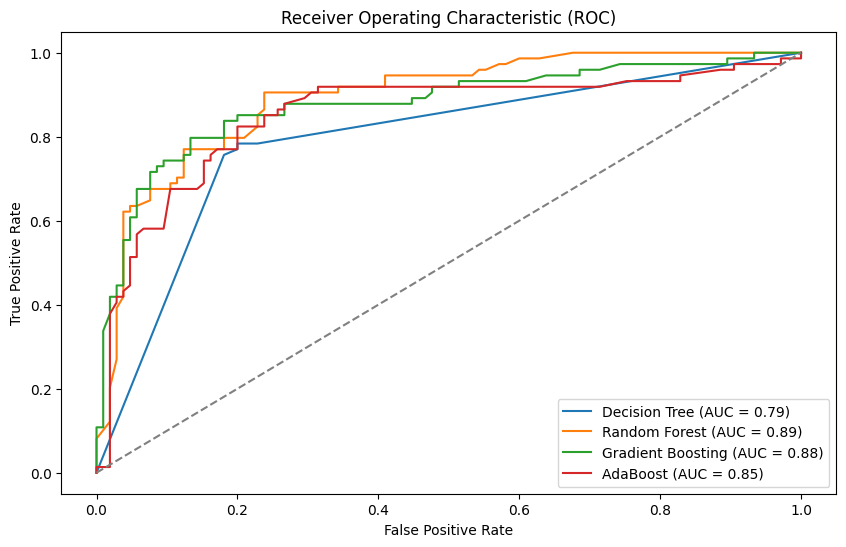

In [5]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
for result in results:
    plt.plot(result['FPR'], result['TPR'], label=f"{result['Classifier']} (AUC = {result['AUC']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()



In [6]:
# Create a bar chart comparing accuracy
accuracy_df = pd.DataFrame(results)
fig = px.bar(accuracy_df, x='Classifier', y='Accuracy', text='Accuracy', title='Classifier Accuracy Comparison')
fig.update_traces(texttemplate='%{text:.2%}', textposition='outside')
fig.show()